<a href="https://colab.research.google.com/github/hyd3nekosuki/RPDsummer2024/blob/main/1DSlabMonteCarlo2024RPDsmr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy.lib.type_check import real_if_close
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from numba import njit

@njit("f8, f8, i4, f8, f8, f8, f8[:], f8, f8", cache=True)
def traceOneNeutronHistory(SigT, pS, NX, dx, Xbcm, Xbcp, albedo, x0, w0):
    wKill = 0.1 # ロシアンルーレットの閾値

    flux = np.zeros(NX)
    weight = w0
    x = x0
    OmegaX = np.random.uniform(-1, 1)
    isAlive = True
    while(isAlive):
        length = -1/SigT * np.log(1-np.random.rand())
        x = x + length*OmegaX
        if x<Xbcm:
            x = Xbcm
            OmegaX *= -1.0
            weight *= albedo[0]
        elif x>Xbcp:
            x = Xbcp
            OmegaX *= -1.0
            weight *= albedo[-1]
        else:
            pos = int((x-Xbcm)/dx)
            flux[pos] += weight/(SigT*dx)
            weight *= pS
            if weight < wKill:
                if np.random.rand() > (weight/wKill):
                    isAlive = False
                    weight=0.0
                else:
                    weight = wKill
            OmegaX = np.random.uniform(-1, 1)
    return flux


@njit(cache=True)
def calcFluxMonteCarlo(SigS, SigA, dx, NX, a, b, c, albedo, Nhist=None):
    if Nhist is None:
        Nhist = 100000 # 固定源計算のヒストリー数

    ycheck = np.zeros(3)
    ycheck[0] = a-b+c
    vx = -b/(2*a)
    if vx>=-1 and vx<=1:
        ycheck[1] = -(b*b-4*a*c)/(4*a)
    ycheck[2] = a+b+c
    ymin = ycheck.min()
    ymax = ycheck.max()
    if ymin < 0 or ymax < 0:
        print(ycheck)

    SigT = SigA + SigS # 全断面積 [1/cm]

    pA = SigA/SigT
    pS = SigS/SigT

    HL = NX*dx/2.0
    Xbcm = -HL #　左側境界面のx座標 [cm]
    Xbcp = +HL # 右側境界面のx座標 [cm]
    w0 = (2.0*a/3.0 + 2*c)*HL

    flux_ave = np.zeros(NX)
    flux2_ave = np.zeros(NX)

    coef3 = a/3.0
    coef2 = b/2.0
    coef1 = c
    coef0 = a/3.0 - b/2.0 +c
    for i in range(Nhist):
        while 1:
            x0 = np.random.uniform(-1.0, 1.0)
            y0 = np.random.uniform(0.0, ymax)
            if y0<=(a*x0*x0 +b*x0 +c):
                x0 = x0*HL
                break
        flux = traceOneNeutronHistory(SigT, pS, NX, dx, Xbcm, Xbcp, albedo, x0, w0)
        flux_ave += flux
        flux2_ave += flux*flux

    flux_ave /= Nhist
    flux2_ave /=Nhist
    flux_err = np.sqrt((flux2_ave - flux_ave**2)/(Nhist-1))

    xplot = np.arange( dx/2, NX*dx, dx ) + Xbcm
    return xplot, flux_ave, flux_err



In [2]:
def ordinal(i):
    j = i%100
    return "{}".format(i)+({1:"st", 2:"nd", 3:"rd"}.get(j if 14>j>10 else j % 10) or "th")

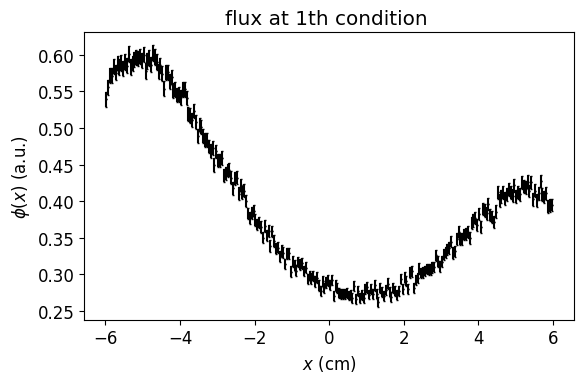

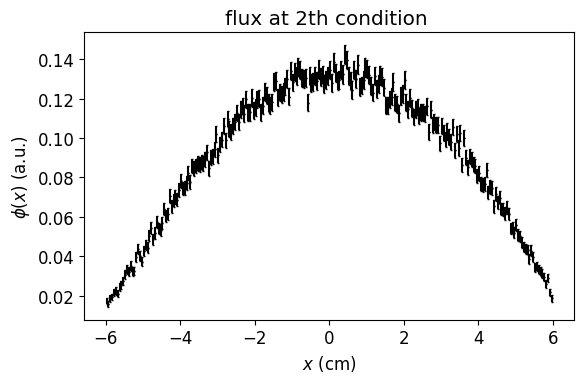

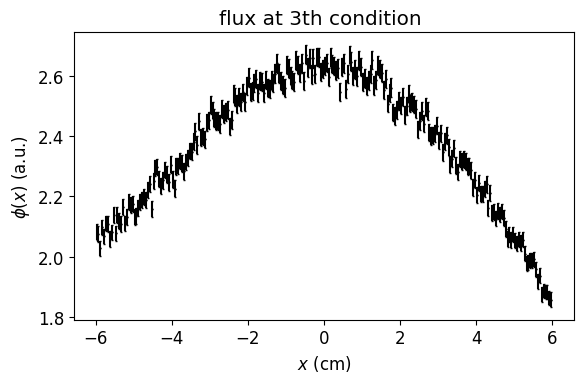

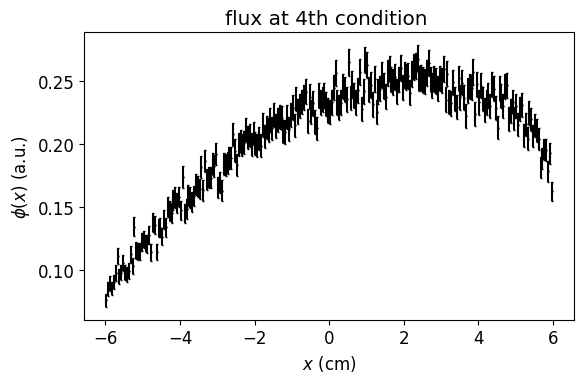

[ 2.28625725e-01 -4.24998792e-18  2.69680196e-01]


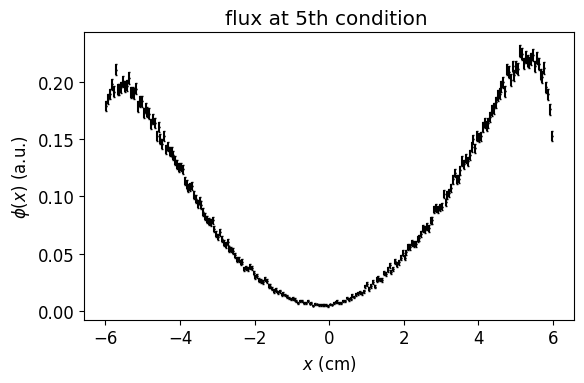

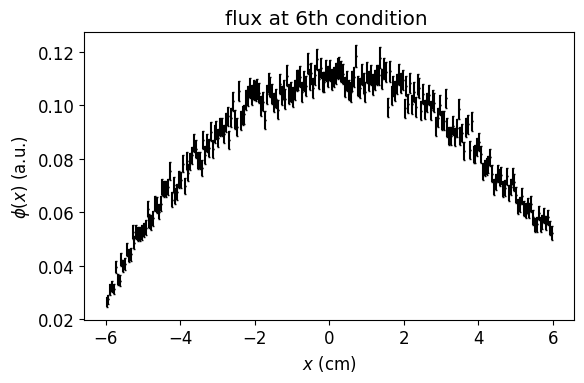

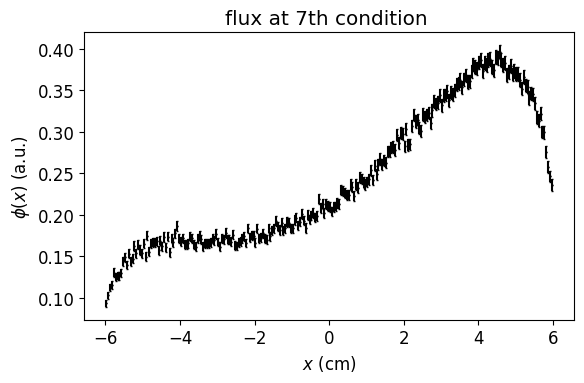

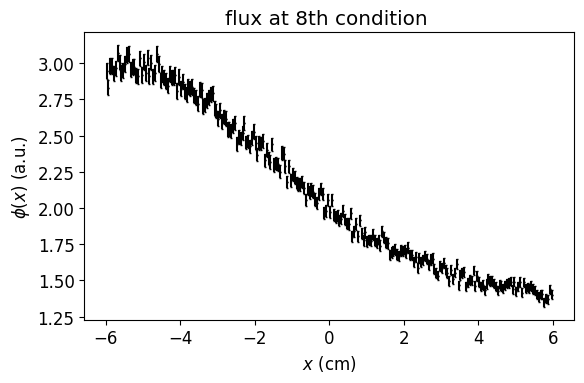

[ 1.90469327e-01 -8.09544105e-18  2.97623337e-01]


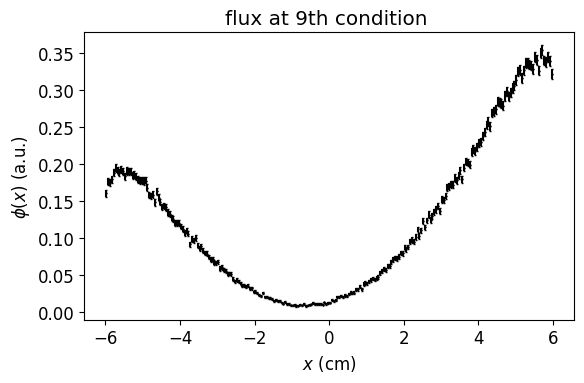

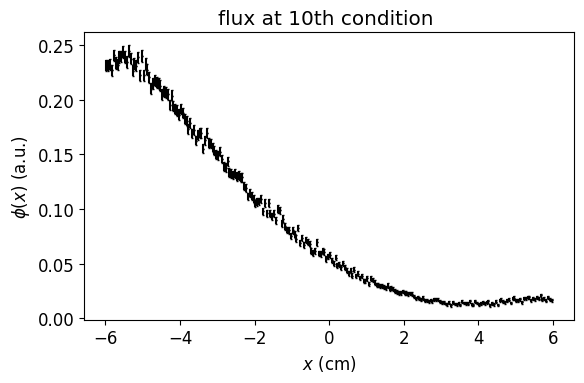

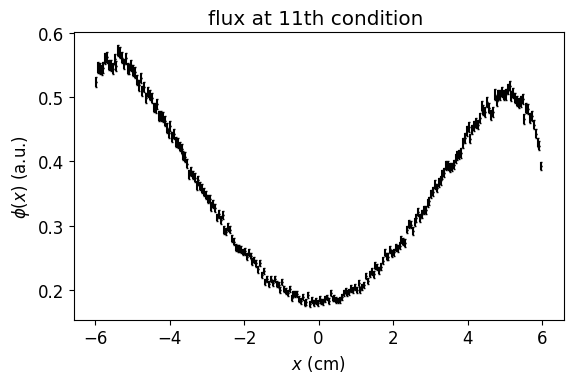

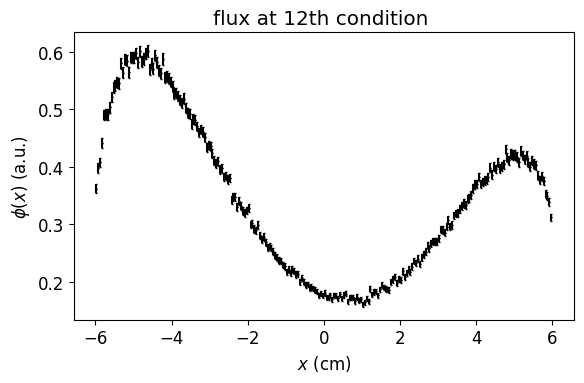

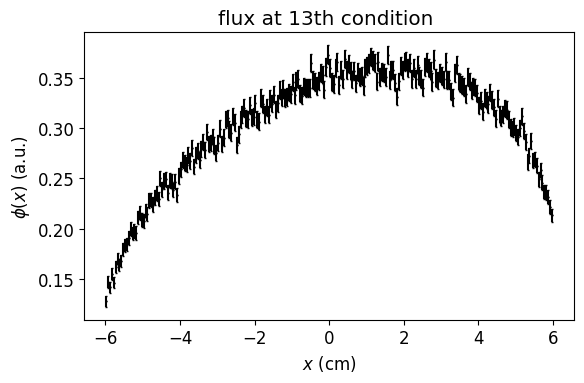

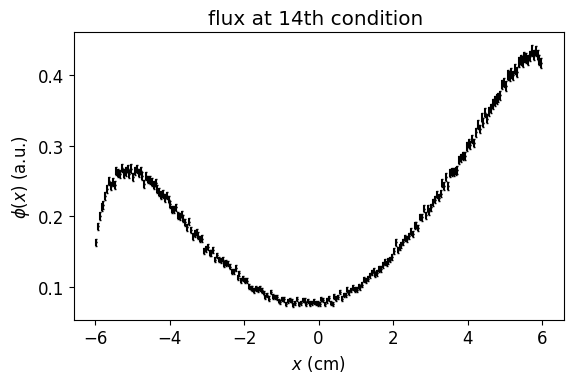

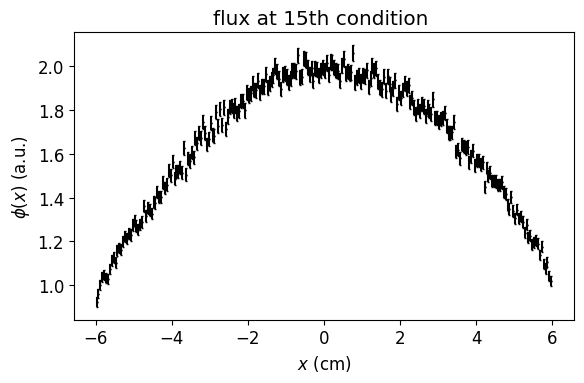

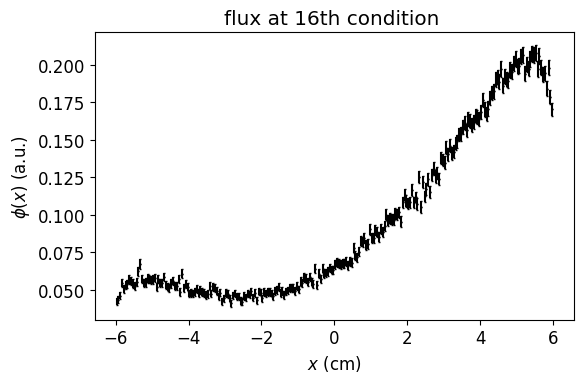

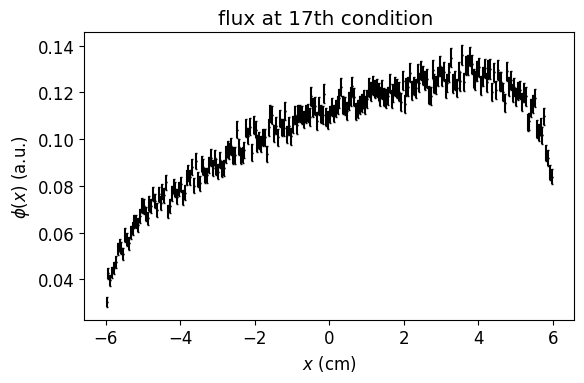

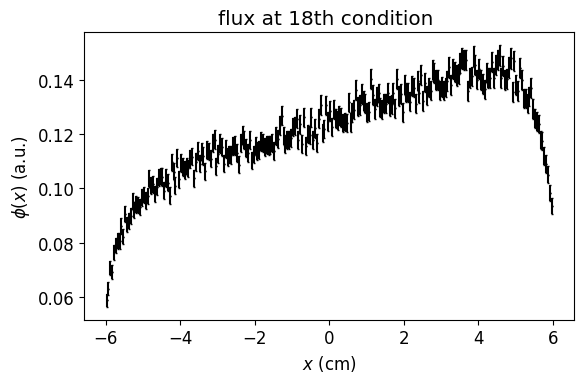

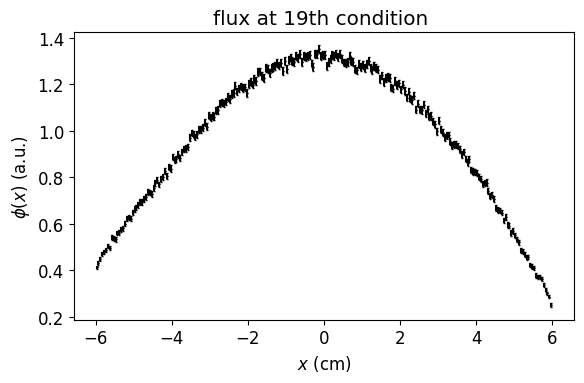

[ 2.09051483e-01 -4.63544721e-18  2.85066446e-01]


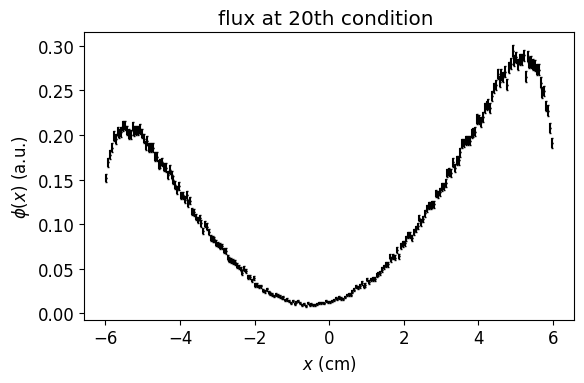

In [3]:
np.random.seed(20240619)

dx = 0.05 # タリーをとる空間メッシュ幅 [cm]
NX = 240 # タリーをとる空間メッシュ数
Nhist = 100000

NC = 20
snapshotF = np.zeros( (NX,NC))

plt.rcParams["figure.figsize"]=(6,4)
plt.rcParams["font.size"] = 12

for i in range(NC):
    SigA = np.random.uniform(low=0.01, high=1.0)
    SigS = np.random.uniform(low=0.01, high=1.0)

    s = np.zeros(NX)
    xi = np.random.uniform(low=-1.0, high=1.0)
    y = np.random.uniform(low=0.0, high=1.0, size=3)
    a = y[0]/(2*(1+xi)) +y[1]/(xi*xi-1) + y[2]/(2*(1-xi))
    b = (y[2]-y[0])/2
    c = xi*( y[0]/(2*(1+xi)) -y[2]/(2*(1-xi)) )  -y[1]/(xi*xi-1)
    vx = -b/(2*a)
    if vx>=-1 and vx<=1:
        vy = -(b*b-4*a*c)/(4*a)
        if vy <0:
            c = c-vy
    stotal = ((a/3)+c)*NX*dx
    a = a/stotal
    b = b/stotal
    c = c/stotal
    albedo = np.random.uniform(low=0.0, high=1.0, size=(2))
    x, flux_ave, flux_err = calcFluxMonteCarlo(SigS, SigA, dx, NX, a, b, c, albedo, Nhist)
    snapshotF[:,i] = flux_ave


    plt.errorbar(x,  flux_ave, yerr = flux_err, capsize=1, fmt='+', markersize=2, ecolor='black', markeredgecolor = "black", color='w')
    plt.title("flux at {}th condition ".format(i+1))
    plt.xlabel("$x$ (cm)")
    plt.ylabel("$\phi(x)$ (a.u.)")
    plt.tight_layout()
    plt.show()
